In [1]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
%matplotlib inline

from baseline_calculator import *
from simple_averaging_recommender import SimpleAveragingRecommender

In [2]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

In [5]:
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)

In [6]:
def X_and_y_of(df):
    return df[['user_id', 'business_id']].values, df['stars'].values

reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

X_train, y_train = X_and_y_of(reviews_train)
X_test, y_test = X_and_y_of(reviews_test)

In [5]:
def summarize_performance(model):
    name = model.__class__.__name__
    print '{} train RMSE: {}'.format(name, model.rmse(X_train, y_train))
    print '{} test RMSE: {}'.format(name, model.rmse(X_test, y_test))

In [6]:
simple_avg = SimpleAveragingRecommender()
simple_avg.fit(X_train, y_train)
summarize_performance(simple_avg)

SimpleAveragingRecommender train RMSE: 0.976644727132
SimpleAveragingRecommender test RMSE: 1.34699149129


In [86]:
from collections import defaultdict
import numpy as np
import sklearn.metrics

class BaselineCalculator():
    def __init__(self):
        self.user_baselines = defaultdict(int)
        self.busi_baselines = defaultdict(int)
        
    def fit(self, reviews):
        raise NotImplementedError("implement me")

    def baseline_rmse(self, reviews): # assumes you've already fit
        return np.sqrt(sklearn.metrics.mean_squared_error(
            self.transform(reviews).starz, np.zeros(len(reviews))))

    def transform(self, reviews, key='starz'):
        reviews[key] = [
            max(1, min(5,
                s - self.global_mean - self.user_baselines[u] - self.busi_baselines[b]))
            for s, u, b in reviews[['stars', 'user_id', 'business_id']].values]
        return reviews
    
    def inverse_transform(self, reviews, predictions):
        return np.array([
            max(1, min(5, 
                s + self.global_mean + self.user_baselines[u] + self.busi_baselines[b]))
            for s, (u, b) in zip(predictions, reviews[['user_id', 'business_id']].values)])
    
class AbsoluteMeanBaselineCalculator(BaselineCalculator):
    def fit(self, reviews):
        self.global_mean = np.mean(reviews.stars.values)
        
class SimpleAverageBaselineCalculator(BaselineCalculator):
    def fit(self, reviews):
        y = reviews.stars.values
        u = reviews.user_id.values
        b = reviews.business_id.values
        mu = np.mean(y)
        self.global_mean = mu
        yu = defaultdict(list)
        yb = defaultdict(list)
        for i, star in enumerate(y):
            yu[u[i]].append(star)
            yb[b[i]].append(star)
        for user, stars in yu.items():
            self.user_baselines[user] = np.mean(stars) - mu
        for busi, stars in yb.items():
            self.busi_baselines[busi] = np.mean(stars) - mu

# The idea here is to map ✮ => 0 and have it linearly increase to ✮✮✮✮✮ => 1.
# That converts our 5-star scale into a 0-1 scale.
# We then initially have a belief about a restaurant's rating centered at a value corresponding to the global mean,
# which we update by considering ✮✮✮✮✮ as V votes in favor, ✮ as V votes against,
# ✮✮✮ as V/2 votes in favor, V/2 votes against, etc.
class BetaPriorBaselineCalculator(BaselineCalculator):
    def fit(self, reviews, prior_strength=10, posterior_strength=1):
        def beta_mode(a, b):
            return (a - 1.0) / (a + b - 2.0)
        
        def beta_stars(a, b): # map from 0-1 scale to stars
            return beta_mode(a, b)*4 + 1
        
        y = reviews.stars.values
        u = reviews.user_id.values
        b = reviews.business_id.values
        mu = np.mean(y)
        self.global_mean = mu

        # If we want Beta(a,b) to have a mode corresponding to μ stars, and we know a+b=prior_strength,
        # the following computes the correct a and b
        beta_a = ((mu-1)/4.)*(prior_strength-2) + 1
        beta_b = prior_strength - beta_a
        if prior_strength > 2:
            assert(abs(beta_stars(beta_a, beta_b) - mu) < 0.0001)

        u_succs = defaultdict(float)
        u_fails = defaultdict(float)
        b_succs = defaultdict(float)
        b_fails = defaultdict(float)
        for i, star in enumerate(y):
            vote = posterior_strength*((star - 1.) / 4) # somewhat arbitrary
            u_succs[u[i]] += vote
            b_succs[b[i]] += vote
            u_fails[u[i]] += posterior_strength - vote
            b_fails[b[i]] += posterior_strength - vote
        for usr in u:
            self.user_baselines[usr] = beta_stars(beta_a + u_succs[usr], beta_b + u_fails[usr]) - mu
        for biz in b:
            self.busi_baselines[biz] = beta_stars(beta_a + b_succs[biz], beta_b + b_fails[biz]) - mu

In [64]:
sabc = SimpleAverageBaselineCalculator()
sabc.fit(reviews_train)
sabc_train_rmse = sabc.baseline_rmse(reviews_train)
sabc_test_rmse = sabc.baseline_rmse(reviews_test)
print(sabc_train_rmse)
print(sabc_test_rmse)

1.09944803849
1.2198753567


In [63]:
ambc = AbsoluteMeanBaselineCalculator()
ambc.fit(reviews_train)
ambc_train_rmse = ambc.baseline_rmse(reviews_train)
ambc_test_rmse = ambc.baseline_rmse(reviews_test)
print(ambc_train_rmse)
print(ambc_test_rmse)

1.10711590353
1.1073316893


In [78]:
bpbc = BetaPriorBaselineCalculator()
prior_strs = list(np.arange(2, 20, 0.5)) + list(np.arange(21, 40, 2)) + list(np.arange(50, 2000, 20))
train_rmses = []
test_rmses = []
for prior_strength in prior_strs:
    bpbc.fit(reviews_train, prior_strength=prior_strength)
    train_rmses.append(bpbc.baseline_rmse(reviews_train))
    test_rmses.append(bpbc.baseline_rmse(reviews_test))

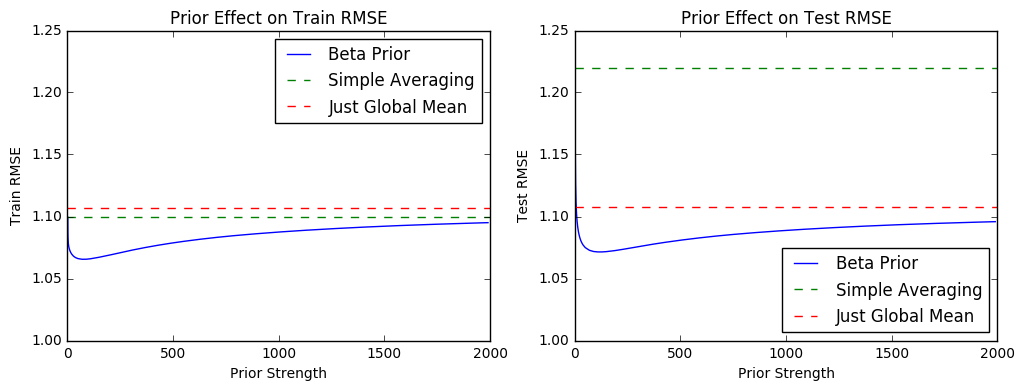

In [79]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, train_rmses, label='Beta Prior')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_train_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')
plt.ylim(1,1.25)

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, test_rmses, label='Beta Prior')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_test_rmse, label='Just Global Mean', ls='--', color='red')
plt.ylim(1,1.25)
plt.legend(loc='best')

plt.show()

In [81]:
prior_strs[np.argmin(test_rmses)]

110

First thing to note -- we actually would have gotten a lower RMSE than simple averaging had we just predicted the global mean for every restaurant. That means our baseline models were actually extremely terrible.

Second thing to note -- our beta priors make sense, because when our prior strength is minimal (at a=b=1, which describes a uniform prior), our RMSE matches simple averaging exactly, and when our prior strength $\to \infty$, it matches just predicting the global mean everywhere. This is good to note! 

In [92]:
sabc = AbsoluteMeanBaselineCalculator()
sabc.fit(reviews_train)
stars = reviews_train.stars
starz = reviews_train.starz
stars_again = sabc.inverse_transform(reviews_train, starz)
print(stars - stars_again)

2573413   -0.744384
1259563    0.011187
2601703    0.009931
746577     0.000000
1044933   -1.744384
394238    -0.744384
48222      0.000000
118058     0.000000
2555699    0.045387
969759    -2.744384
130352    -0.744384
2185813    0.047171
1933505    0.028534
1889852    0.000000
2046806    0.037954
1996315   -2.744384
352951     0.001547
2122587    0.065762
703112     0.101895
2567731    0.026060
1044519    0.040676
988937    -2.744384
1670355   -1.744384
193655    -3.744384
1476377   -3.744384
2627536    0.022451
820788     0.000000
1239193    0.008369
1263085    0.005421
365584    -1.744384
             ...   
1393824   -1.744384
2024534    0.004783
702776     0.102616
2369526   -1.744384
2582488    0.014972
1730331   -0.744384
124692     0.000000
2493934   -3.744384
2336218   -1.744384
1240405   -2.744384
2179188    0.010301
332650    -0.744384
1656165    0.022725
1498712   -1.744384
1116084   -3.744384
422603    -2.744384
181960     0.017332
2037812   -0.744384
2419265   -0.744384


In [93]:
reviews_train

,user_id,business_id,year,month,day,stars,starz
2573413,512719,79964,2016,6,24,4,1.000000
1259563,534944,35674,2014,6,25,5,1.244428
2601703,651956,81267,2016,3,26,5,1.245684
746577,427777,20986,2010,12,13,5,1.255616
1044933,446482,28575,2009,8,22,3,1.000000
394238,462187,16242,2014,8,26,4,1.000000
48222,155197,2420,2011,1,7,5,1.259656
118058,336599,4838,2014,4,5,5,1.256821
2555699,581994,79183,2016,4,4,5,1.210229
969759,56886,27603,2015,9,1,2,1.000000


In [26]:
#matrix_fac = MatrixFactorizationRecommender()
#matrix_fac.fit(X_train, y_train)
#summarize_performance(matrix_fac)

Model file already exists, skipping vowpal-wabbit fitting
MatrixFactorizationRecommender train RMSE: 1.19438634692
MatrixFactorizationRecommender test RMSE: 1.19719273998
MatrixFactorizationRecommender train R^2: 0.218975203111
MatrixFactorizationRecommender test R^2: 0.218121785367
